In [1]:
class Line():
    def __init__(self, fit):
        self.curvature = 0
        self.fit = fit
        self.fitx = []
    def check(self,curv):
        if(np.abs(curv-self.curvature) >= 3000):
            return False
        return True
    def update(self, curv, fit):
        self.curvature = curv
        self.fit = fit
left = Line([ 1.22120921e-04, -1.49160585e-01,  3.29075123e+02])
right = Line([2.90910728e-04, -2.05179515e-01,  1.08280543e+03])

In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob as glob 

def calibrate_camera():
    imgs = glob.glob('./camera_cal/*.jpg')
    objpoints = []
    imgpoints = []
    for img in imgs:
        img = cv2.imread(img)
        objp = np.zeros((6*9, 3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = calibrate_camera()

In [3]:
def distortion_correction(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def abs_sobel_thresh(img, orient='x', thresh=(20,100), sobel_kernel=3):
    thresh_min, thresh_max, = thresh
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) #We apply the sobel operator to the gray image
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel) # We get the absolute value of the image
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # we convert the absolute value to an 8-bit image
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 # we filter out parts of the image not within the threshold range
    return sxbinary

def hls_select(img, threshold=(170, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_image = gray[:,:,2]
    binary_output = np.zeros_like(s_image)
    binary_output[(s_image > threshold[0]) & (s_image <= threshold[1])] = 1
    return binary_output

In [4]:
def find_lane_pixels_full(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 90
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox <= win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))        

        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    out_img[lefty,leftx] = [0,0,255]
    out_img[righty,rightx] = [255,0,0]
    
    return leftx, lefty, rightx, righty, out_img

In [5]:
def find_lane_pixels(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_fit = left.fit
    right_fit = right.fit
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin) &
     (nonzerox < left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin)).nonzero()[0]
    right_lane_inds = ((nonzerox > right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin) & 
    (nonzerox < right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin)).nonzero()[0]

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
        
    color_warp[lefty,leftx] = [0,0,255]
    color_warp[righty,rightx] = [255,0,0]
    
    
    return leftx, lefty, rightx, righty, color_warp

In [6]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[275, 699],
        [1085, 681],
        [769, 487],
        [546, 487],        
        ])
    dst = np.float32([
        [285, 691],
        [1080, 691],
        [1080, 100],
        [285, 100], 
        ])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, dst, src

In [254]:
def unwarp(warped, dst, src, left_fitx, right_fitx):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    bottom_x = color_warp[718:,:].nonzero()[1] #We get access to the pixles at the bottom lane segment
    middle_of_lane = min(bottom_x) + (max(bottom_x) - min(bottom_x))/2
    offset = (middle_of_lane-640)*3.7/798
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]))
    
    # To find the offset I found the average of the x_values in the warped image
    # and by how much it differed from the center of the image
    # TODO: check if this is a valid method
    return newwarp, offset

In [98]:
def unwarp2(warped, dst, src):
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(warped, Minv, (warped.shape[1], warped.shape[0]))
    return newwarp

In [99]:
def measure_curvature(binary_warped, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/785 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad =  np.power((1+np.power((2*left_fit[0]*y_eval + left_fit[1]),2)),1.5)/np.abs(2*left_fit[0])## Implement the calculation of the left line here
    right_curverad = np.power((1+np.power((2*right_fit[0]*y_eval + right_fit[1]),2)),1.5)/np.abs(2*right_fit[0])  ## Implement the calculation of the ri  ght line here
    
    return left_curverad, right_curverad

In [100]:
def mag_thresh(img, mag_thresh, sobel_kernel):
    thresh_min, thresh_max, = mag_thresh
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) #We apply the sobel operator to the gray image
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = pow(sobelx,2) + pow(sobely, 2)
    sobel = pow(sobel, 0.5) #Find the magnitude of both the x and y gradien values
    abs_sobel = np.absolute(sobel) # We get the absolute value of the image
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # we convert the absolute value to an 8-bit image
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 # we filter out parts of the image not within the threshold range
    return sxbinary

In [101]:
def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, lane_image = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    left_curvature, right_curvature = measure_curvature(binary_warped, left_fit, right_fit)
    
    if(left.check(left_curvature) == False or right.check(right_curvature) == False):
        leftx, lefty, rightx, righty, lane_image = find_lane_pixels_full(binary_warped)
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_curvature, right_curvature = measure_curvature(binary_warped, left_fit, right_fit)
        left.update(left_curvature, left_fit)
        right.update(right_curvature, right_fit)
        
    return left_fitx, right_fitx, lane_image

In [102]:
# Load our image
def find_lane(image):
    if(image.shape != (720, 1280, 3)):
        image = cv2.resize(image, (1280, 720), interpolation = cv2.INTER_AREA)
        
    undistorted_image = distortion_correction(image)
    sobel_x = abs_sobel_thresh(undistorted_image)
    s_segment = hls_select(undistorted_image)
    final_combination = np.zeros_like(s_segment)
    final_combination[(s_segment == 1) | (sobel_x == 1)] = 1
    warped, dst, src = warp(final_combination)
    
    left_fitx, right_fitx, lane_image = fit_polynomial(warped)

    unwarped, offset = unwarp(final_combination, dst, src, left_fitx, right_fitx)
    lane_image = unwarp2(lane_image, dst, src)
    
    result = cv2.addWeighted(undistorted_image, 1, unwarped, 0.2, 0)
    result = cv2.addWeighted(lane_image, 1, result, 0.8, 0)
    
    # Print curvature
    cv2.putText(result, 'Radius of curvature = {}m'.format(round(np.sum(measure_curvature(undistorted_image, left.fit, right.fit))/2),2), (20,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    if offset > 0:
        cv2.putText(result, 'Vehicle is {}m left of center'.format(round(offset,2)), (20,270), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    else:
        cv2.putText(result, 'Vehicle is {}m right of center'.format(round(offset,2)*-1), (20,270), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    return result

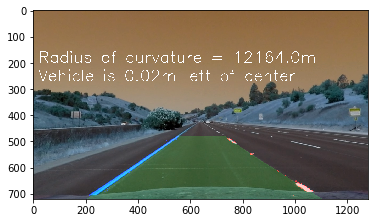

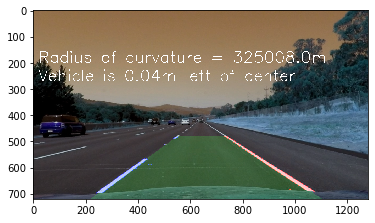

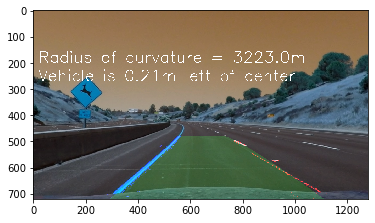

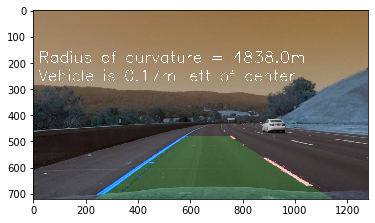

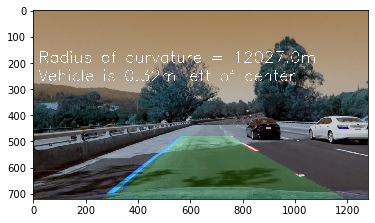

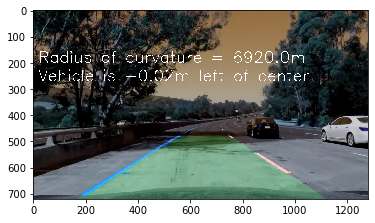

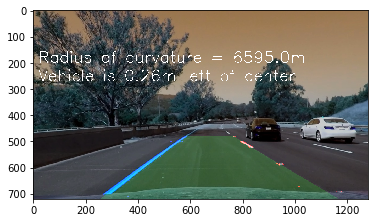

In [255]:
imgs = glob.glob('./test_images/*.jpg')
for i, img in enumerate(imgs):
    image = cv2.imread(img)
    result = find_lane(image)
    plt.imshow(result)
    cv2.imwrite('./output_images/test'+str(i)+'.jpg',result)   
    plt.show()

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'output_images/project_video2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(find_lane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
image = cv2.imread('test_images/test2.jpg')
undistorted_image = distortion_correction(image)
sobel_x = abs_sobel_thresh(undistorted_image)
s_segment = hls_select(undistorted_image)
final_combination = np.zeros_like(s_segment)
final_combination[(s_segment == 1) | (sobel_x == 1)] = 1
warped, dst, src = warp(final_combination)
plt.imshow(warped)
plt.show()